# Download and Mosaic Multiple 3DEP DTM Tiles

This code is adapted (by Hannah Besso) from David Shean's geospatial_cookbook_rendered.ipynb notebook created for UW's SnowEx Hackweek 2021

### This notebook does the following:
* Read in a list of urls linking to individual 3DEP tiles that cover Grand Mesa
* Downloads, reprojects, and mosaics the tiles using gdal
* Clips the mosaic'd image to the flat top of Grand Mesa

In [2]:
import os
import rasterio as rio
import rasterio.plot
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

In [3]:
url_fn_3DEP = 'gm_3dep_1m_lidar_tiles.txt'

In [4]:
with open(url_fn_3DEP) as f:
    url_list = f.read().splitlines()

In [5]:
url_list.sort()

In [6]:
path_list = []
for url in url_list:
    #fn = os.path.splitext(os.path.split(url)[-1])[0]+'.img'
    #path = f'/vsizip//vsicurl/{url}/{fn}'
    path = f'/vsicurl/{url}'
    path_list.append(path)
path_list_str = ' '.join(path_list)

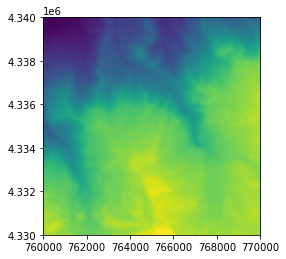

In [12]:
# with rio.open(path) as src:
#     rio.plot.show(src)

In [37]:
#src.crs

CRS.from_epsg(26912)

In [10]:
#url = 'https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1m/Projects/CO_MesaCo_QL2_UTM12_2016/TIFF/USGS_one_meter_x74y433_CO_MesaCo_QL2_UTM12_2016.tif'

In [13]:
#path = f'/vsicurl/{url}'

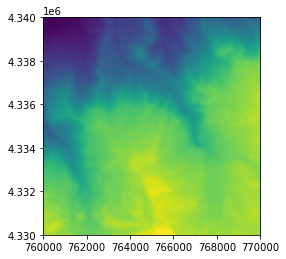

In [14]:
# with rio.open(path) as src:
#     rio.plot.show(src)

In [7]:
url = open("url_list.txt", "w")

for element in url_list:

    url.write(element + "\n")

url.close()

In [8]:
#url_fn_3DEP = 'url_list.txt'

In [9]:
vrt_fn = os.path.splitext(url_fn_3DEP)[0]+'.vrt'
tif_fn = os.path.splitext(url_fn_3DEP)[0]+'.tif'
#hs_fn = os.path.splitext(tif_fn)[0]+'_hs.tif'

In [10]:
#This actually takes some time as file must be downloaded and unzipped to read img header
!gdalbuildvrt -quiet $vrt_fn $path_list_str

Warning 6: gdalbuildvrt does not support heterogeneous projection: expected NAD83 / UTM zone 13N, got NAD83 / UTM zone 12N. Skipping /vsicurl/https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1m/Projects/CO_MesaCo_QL2_UTM12_2016/TIFF/USGS_one_meter_x73y431_CO_MesaCo_QL2_UTM12_2016.tif
Warning 6: gdalbuildvrt does not support heterogeneous projection: expected NAD83 / UTM zone 13N, got NAD83 / UTM zone 12N. Skipping /vsicurl/https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1m/Projects/CO_MesaCo_QL2_UTM12_2016/TIFF/USGS_one_meter_x73y432_CO_MesaCo_QL2_UTM12_2016.tif
Warning 6: gdalbuildvrt does not support heterogeneous projection: expected NAD83 / UTM zone 13N, got NAD83 / UTM zone 12N. Skipping /vsicurl/https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1m/Projects/CO_MesaCo_QL2_UTM12_2016/TIFF/USGS_one_meter_x73y433_CO_MesaCo_QL2_UTM12_2016.tif
Warning 6: gdalbuildvrt does not support heterogeneous projection: expected NAD83 / UTM zone 13N, got NAD83 / UTM zone

In [11]:
dst_crs = 'EPSG:32612'

In [12]:
#Since these tiles are mixed projection, can download, reproject and mosaic in one go
!gdalwarp -q -r cubic -tr 3.0 3.0 -dstnodata -9999 -t_srs $dst_crs \
-co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER \
$path_list_str $tif_fn

ERROR 1: Output dataset url_list.tif exists,
but some command line options were provided indicating a new dataset
should be created.  Please delete existing dataset and run again.



In [18]:
src = rio.open('/home/jovyan/space_lasers/notebooks/gm_3dep_1m_lidar_tiles.tif')

In [14]:
tif_fn

'url_list.tif'

In [19]:
src.profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 5070, 'height': 3264, 'count': 1, 'crs': CRS.from_epsg(32612), 'transform': Affine(3.0, 0.0, 737688.5474426108,
       0.0, -3.0, 4330434.375353689), 'tiled': False, 'interleave': 'band'}

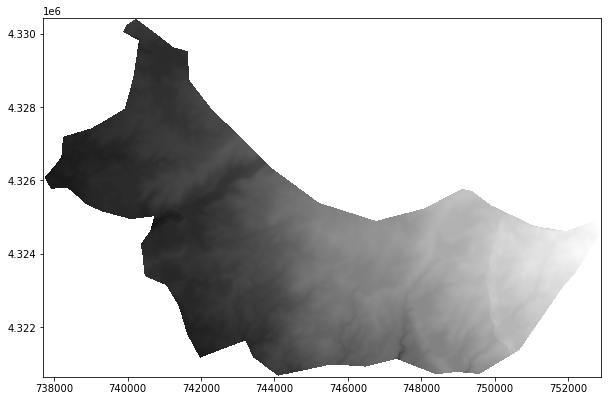

<AxesSubplot:>

In [20]:
fig, ax = plt.subplots(figsize=(10,10))
rio.plot.show(src, cmap='gray')

In [23]:
poly_fn = '/home/jovyan/space_lasers/notebooks/grand_mesa_poly.geojson'

In [2]:
tighter_poly_fn = '/home/jovyan/space_lasers/notebooks/map.geojson'

In [3]:
gm_poly = gpd.read_file(tighter_poly_fn)

<AxesSubplot:>

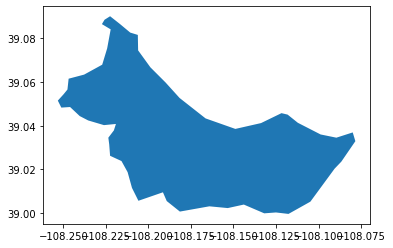

In [4]:
gm_poly.plot()

In [5]:
gm_poly.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
gm_poly = gm_poly.to_crs(crs='epsg:32612')

In [7]:
gm_poly.to_file("/home/jovyan/space_lasers/notebooks/GM_tight_poly_32612.geojson", driver='GeoJSON')

In [16]:
gm_fn = "/home/jovyan/space_lasers/notebooks/GM_tight_poly_32612.geojson"
tif_fn = '/home/jovyan/space_lasers/notebooks/gm_3dep_1m_lidar_tiles.tif'

In [9]:
import fiona
import rasterio
import rasterio.mask

with fiona.open(gm_fn, "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

In [17]:
gm_tif = rio.open(tif_fn)

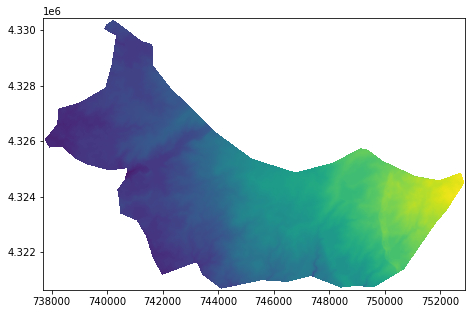

<AxesSubplot:>

In [21]:
fig, ax = plt.subplots(figsize=(10,5))
#plt.savefig('3DEP_GM.jpeg', dpi=300)
rio.plot.show(gm_tif)

In [8]:
type(shapes)

list

In [11]:
with rio.open(tif_fn) as src:
    out_image, out_transform = rio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta

In [12]:
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open(tif_fn, "w", **out_meta) as dest:
    dest.write(out_image)

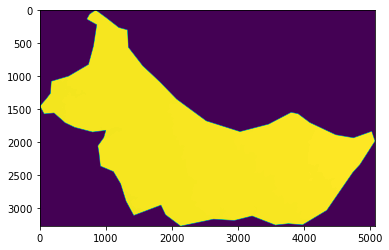

<AxesSubplot:>

In [13]:
rio.plot.show(out_image)